In [66]:
import pandas as pd
import numpy as np
import warnings 
import nltk
import matplotlib.pyplot as plt
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
import re
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, hamming_loss
from sklearn.metrics import jaccard_score 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from gensim.models import LdaModel
from gensim.models.coherencemodel import CoherenceModel
from gensim import corpora
from gensim.corpora import Dictionary
from gensim.matutils import corpus2dense  # Import corpus2dense function from gensim.matutils
from gensim.matutils import Sparse2Corpus
from datetime import datetime, time
import pickle

In [30]:
import pyLDAvis
import pyLDAvis.gensim_models

In [31]:
warnings.filterwarnings('ignore')

In [32]:
data =  pd.read_csv('data_processed.csv',  engine = 'python',  on_bad_lines = 'skip')

In [33]:
data.columns

Index(['Id', 'Title', 'Title_tokens', 'Body', 'Body_tokens', 'Tags',
       'Tag_token', 'Score', 'AnswerCount'],
      dtype='object')

In [34]:
data.shape

(50000, 9)

In [35]:
X = data[['Title_tokens', 'Body_tokens','Tag_token','Score', 'AnswerCount']]
y = data[['Tag_token']]

# re tokenisations des variables tockens suite à la lecture csv qui lit champe en string,  mise à jour aussi dans dataframe data. 
X['Title_tokens'] = X['Title_tokens'].apply(lambda x: re.sub('[^a-zA-Z_]', ' ', str(x)))
X['Title_tokens'] = X['Title_tokens'].apply(nltk.word_tokenize)
X['Body_tokens'] = X['Body_tokens'].apply(lambda x: re.sub('[^a-zA-Z_]', ' ', str(x)))
X['Body_tokens'] = X['Body_tokens'].apply(nltk.word_tokenize)
X['Tag_token'] = X['Tag_token'].apply(lambda x: re.sub('[^a-zA-Z_]', ' ', str(x)))
X['Tag_token'] = X['Tag_token'].apply(nltk.word_tokenize)

# Split the Title_tokens into train and test sets
X_train, X_test = train_test_split(X, test_size=0.2, random_state=42)

X_train_title = X_train['Title_tokens']
X_test_title = X_test['Title_tokens']
X_train_body = X_train['Body_tokens']
X_test_body = X_test['Body_tokens']
X_train_tag = X_train['Tag_token']
X_test_tag = X_test['Tag_token']

In [36]:
X_train_title.head()

39087                                  [stored, procedure]
30893                         [run, fly, tomcat, netbeans]
45278    [show, gray, color, view, io, navigation, bar,...
16398    [form, authentication, ticket, decryption, pos...
13653                                    [validation, yii]
Name: Title_tokens, dtype: object

In [37]:
X_test_tag.head()

33553         [javascript, jquery, html, css, tablesorter]
9427               [php, mysql, file, codeigniter, upload]
199      [python, python, x, csv, dictionary, multidime...
12447               [php, net, frameworks, ldap, openldap]
39489    [vue, js, vuejs, datepicker, vue, component, v...
Name: Tag_token, dtype: object

# 3. Modèles non supervisés

Nous utilisons LDA comme le modèle non supervisé.  LDA entrainé est utilisée pour découvrir des sujets cachés dans les nouveaux documents. 
Les mots les plus probables dans ces sujets découverts sont généralement considérés comme les mots-clés les plus pertinents pour le document.

In [38]:
performance_list = []
pyLDAvis.enable_notebook()

In [39]:
train_result = pd.DataFrame(performance_list, columns=['Date', 'Modele', 'nb topics', 'perplexity', 'coherence_score'])
train_result.to_csv('lda_train_result.csv')

# 3.1 Entrainement et nombre de topics

In [40]:
def lda_train(num_topics, X_train):
    # Create a dictionary and bag-of-words representation of the training data
    dictionary = Dictionary(X_train)
    bow_corpus = [dictionary.doc2bow(doc) for doc in X_train]
    
    # Train the LDA model
    lda_model = LdaModel(corpus=bow_corpus, num_topics=num_topics, id2word=dictionary)

    topics = lda_model.get_document_topics(bow_corpus)
    
    #  Visulisation des topics 
#    vis = pyLDAvis.gensim_models.prepare(topic_model=lda_model, corpus=bow_corpus, dictionary=dictionary, mds='mmds', R=30)
    vis = pyLDAvis.gensim_models.prepare(topic_model=lda_model, corpus=bow_corpus, dictionary=dictionary, mds='pcoa', sort_topics=True)
    
    # Calculer la perplexité
    perplexity = lda_model.log_perplexity(bow_corpus)

    # Calculer la cohérence des topics
    coherence_model = CoherenceModel(model=lda_model, texts=X_train, corpus=bow_corpus, coherence='c_v')
    coherence_score = coherence_model.get_coherence()
    
    return perplexity, coherence_score, lda_model, vis

In [46]:
# fonction to display the curb and find the ebow
def pca_component(X_train):
    
    # Créez la représentation BoW en utilisant CountVectorizer
    X_train_flat = [" ".join(doc) for doc in X_train]
    vectorizer = CountVectorizer()
    bow_matrix = vectorizer.fit_transform(X_train_flat)
    print("Shape of bow_matrix:", bow_matrix.shape, "nb var= ", bow_matrix.shape[1])
  
    # Appliquez l'ACP pour réduire la dimension à 1000
    n = bow_matrix.shape[1]
    pca = PCA(n_components=n)
    reduced_bow = pca.fit_transform(bow_matrix.toarray())
    print("Shape of reduced_bow:", reduced_bow.shape)
          
    scree = (pca.explained_variance_ratio_*100).round(2)
    scree_cum = scree.cumsum().round()
    
    x_list = range(1, n+1)
    list(x_list)
    plt.bar(x_list, scree)
    plt.plot(x_list, scree_cum, c="red", marker='.')
    plt.xlabel("rang de l'axe d'inertie")
    plt.ylabel("pourcentage d'inertie")
    plt.title("Eboulis des valeurs propres")
    plt.show(block=False)
    
    return

In [48]:
def pca_reduction(X_train, n_components, top_wards): 
# Créez la représentation BoW en utilisant CountVectorizer
    X_train_flat = [" ".join(doc) for doc in X_train]
    vectorizer = CountVectorizer()
    bow_matrix = vectorizer.fit_transform(X_train_flat)
    print("Shape of bow_matrix:", bow_matrix.shape, "nb var= ", bow_matrix.shape[1])
  
    # Appliquez l'ACP pour réduire la dimension à 1000
    n = n_components
    pca = PCA(n_components=n)
    reduced_bow = pca.fit_transform(bow_matrix.toarray())
    print("Shape of reduced_bow:", reduced_bow.shape)
    
    # Get the feature names from CountVectorizer (terms in the BoW matrix)
    feature_names = vectorizer.get_feature_names_out()

    # computes the indices of the top 'n' important terms in each principal component obtained from the PCA reduction.
    top_indices = np.argsort(pca.components_, axis=1)[:, -top_wards:]

    print("Top indices:", top_indices)
    print("Feature names:", feature_names)

    # Step 1: Create a list of tokens for each document/component (similar to X_train)
    new_list = []
    for indices in top_indices:
        terms = [feature_names[j] for j in indices]
        new_list.append(terms)

    # Step 2: Create the new dictionary using the tokens in new_list
    new_dictionary = Dictionary(new_list)    
    
    # Step 3: Display the total number of unique words in the new dictionary
    total_unique_words = len(new_dictionary)
    print("Total unique words in new dictionary:", total_unique_words)

    # Step 4: Display the first 10 words in the new dictionary
    first_10_words = list(new_dictionary.token2id.keys())[:10]
    print("First 10 words in new dictionary:", first_10_words)

    # Convert reduced_bow back to the BoW format with term frequencies
    corpus_for_lda = []
    for doc in reduced_bow:
        term_freqs = [(index, freq) for index, freq in enumerate(doc) if freq != 0.0]
        corpus_for_lda.append(term_freqs)
        
    print("Shape of corpus_for_lda:", len(corpus_for_lda))
    return new_dictionary, corpus_for_lda

In [61]:
import datetime, time

def lda_train_pca(num_topics, X_train):
    
    start_time = time.time()
    
    dictionary, corpus = pca_reduction(X_train, 1000, 5)
    # Train the LDA model
    lda_model = LdaModel(corpus=corpus, num_topics=num_topics, id2word=dictionary)
    
    end_time = time.time()   
    execution_time = end_time - start_time
    print(" exec time(s) : ", execution_time)
    
    return lda_model, dictionary, corpus, execution_time

In [ ]:
    
    # Normalizing the topic_term_dists matrix
    topic_term_dists = lda_model.get_topics()
    row_sums = topic_term_dists.sum(axis=1)
    topic_term_dists_normalized = topic_term_dists / row_sums[:, np.newaxis] 

    # Convert the doc_topic_dists to a NumPy array
    doc_topic_dists = np.array(lda_model.get_document_topics(corpus_for_lda))

    # Normalizing the doc_topic_dists matrix
    row_sums = doc_topic_dists.sum(axis=1)
    doc_topic_dists_normalized = doc_topic_dists / row_sums[:, np.newaxis]

    # Calculate document lengths (number of tokens) for each document in the corpus
    doc_lengths = [len(doc) for doc in corpus_for_lda]
    
    # Calculate term frequency for each term in the corpus
    term_frequency = {term_id: freq for term_id, freq in new_dictionary.cfs.items()}

    # Now you can call the prepare function
    vis = pyLDAvis.prepare(topic_term_dists=topic_term_dists_normalized, doc_topic_dists=doc_topic_dists_normalized, 
                       doc_lengths=doc_lengths, vocab=new_dictionary, term_frequency=term_frequency, mds='pcoa', sort_topics=True)
    
    

Test parts 

Shape of bow_matrix: (40000, 7061) nb var=  7061
Shape of reduced_bow: (40000, 7061)


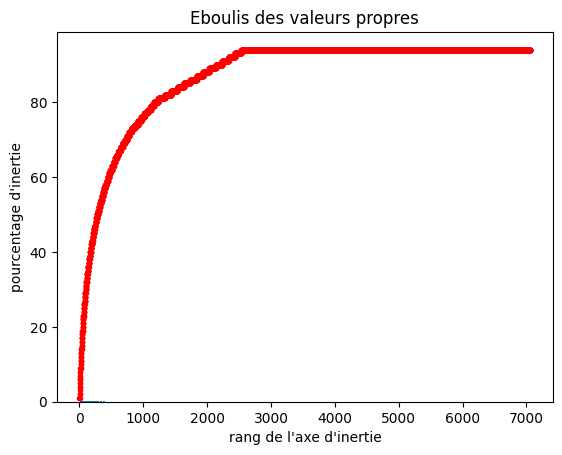

In [47]:
# détermiber le nombre de composant principaux 
pca_component(X_train_title)

In [50]:
num_topics = 10

In [62]:
lda_model_pca, dictionary_pca, corpus_pca, time = lda_train_pca(num_topics, X_train_title)

Shape of bow_matrix: (40000, 7061) nb var=  7061
Shape of reduced_bow: (40000, 1000)
Shape of top_indices: (1000, 5)
Top indices: [[6818 1361  265 5810 5507]
 [5937 5810 5507  327 4056]
 [ 905  265 4056  219 3053]
 ...
 [1877  692 2794 3294 4680]
 [2104 3435 3170  180 6214]
 [1476 5867 1277 1436 3937]]
Feature names: ['__init__' '__m' '_general_ci' ... 'zuul' 'zxing' 'zynq']
Reduced bow: [[ 0.02424034  0.00371976 -0.02821006 ...  0.0018339  -0.0015827
  -0.00425892]
 [ 0.01304506 -0.05263748 -0.00595423 ...  0.04723468 -0.00560436
   0.0078058 ]
 [-0.02707463 -0.2612685  -0.01310324 ... -0.0036464   0.01046614
   0.0052351 ]
 ...
 [ 0.18282745 -0.20909992  0.14309357 ... -0.00794629 -0.02375205
  -0.02469952]
 [-0.01248574 -0.04083209 -0.0097736  ... -0.00937894  0.00421267
   0.00664053]
 [-0.01250627 -0.00483196 -0.01380366 ... -0.00736942 -0.00334204
  -0.00111198]]
Total unique words in new dictionary: 1097
First 10 words in new dictionary: ['app', 'database', 'server', 'sql', 'web

In [64]:
vis = pyLDAvis.gensim_models.prepare(topic_model=lda_model_pca, corpus=corpus_pca, \
                                     dictionary=dictionary_pca, mds='pcoa', sort_topics=True)

ValidationError: 
 * Not all rows (distributions) in topic_term_dists sum to 1.
 * Not all rows (distributions) in doc_topic_dists sum to 1.

In [74]:
# Normalizing the topic_term_dists matrix
topic_term_dists = lda_model_pca.get_topics()
row_sums = topic_term_dists.sum(axis=1)
topic_term_dists_normalized = topic_term_dists / row_sums[:, np.newaxis] 

# Convert the doc_topic_dists to a NumPy array
doc_topic_dists = np.array(lda_model_pca.get_document_topics(corpus_pca))

# Normalizing the doc_topic_dists matrix
row_sums = doc_topic_dists.sum(axis=1)
doc_topic_dists_normalized = doc_topic_dists / row_sums[:, np.newaxis]

# Calculate document lengths (number of tokens) for each document in the corpus
doc_lengths = [len(doc) for doc in corpus_pca]
    
# Calculate term frequency for each term in the corpus
term_frequency = {term_id: freq for term_id, freq in new_dictionary.cfs.items()}

# Now you can call the prepare function
vis = pyLDAvis.prepare(topic_term_dists=topic_term_dists_normalized, doc_topic_dists=doc_topic_dists_normalized, 
                       doc_lengths=doc_lengths, vocab=new_dictionary, term_frequency=term_frequency, mds='pcoa', sort_topics=True)
    

NameError: name 'new_dictionary' is not defined

In [67]:
with open('lda_model_pca.pkl', 'wb') as model_file:
    pickle.dump(lda_model_pca, model_file)
with open('dictionary_pca.pkl', 'wb') as dictionary_file:
    pickle.dump(dictionary_pca, dictionary_file) 

### 3.1.1 Modèle 1: LDA entrainement avec titre

Shape of bow_matrix: (40000, 7061) nb var=  7061
Shape of reduced_bow: (40000, 1000)
Shape of top_indices: (1000, 5)
Top indices: [[6818 1361  265 5810 5507]
 [5937 5810 5507  327 4056]
 [ 905  265 4056  219 3053]
 ...
 [7032 2352 5776 3170 1153]
 [6530 1721  949 1062 3430]
 [ 798 2705   98 5320 3342]]
Feature names: ['__init__' '__m' '_general_ci' ... 'zuul' 'zxing' 'zynq']
Reduced bow: [[ 0.02424035  0.00371976 -0.02821004 ...  0.00304512  0.00077659
  -0.00042077]
 [ 0.01304506 -0.05263739 -0.00595429 ...  0.01468076 -0.00530773
  -0.0056027 ]
 [-0.02707463 -0.26126849 -0.01310322 ...  0.00364108  0.00536154
  -0.00164906]
 ...
 [ 0.18282745 -0.20909989  0.14309357 ... -0.01955965  0.0006313
  -0.00385429]
 [-0.01248572 -0.04083208 -0.00977363 ...  0.00245622 -0.02707162
   0.00984617]
 [-0.01250628 -0.00483197 -0.01380368 ... -0.00472984  0.0057885
   0.00378095]]
Total unique words in new dictionary: 1098
First 10 words in new dictionary: ['app', 'database', 'server', 'sql', 'web'

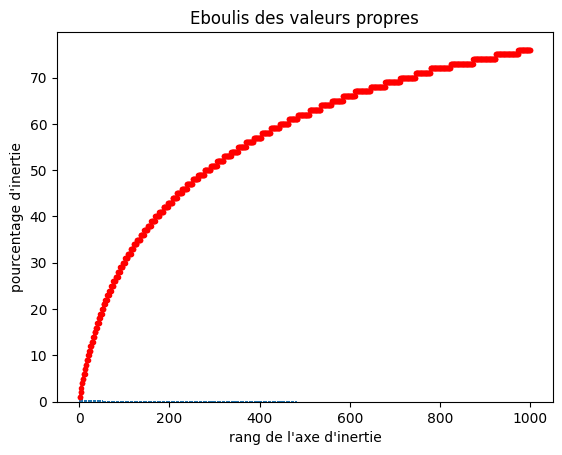

ValidationError: 
 * Number of rows of topic_term_dists does not match number of columns of doc_topic_dists; both should be equal to the number of topics in the model.
 * Not all rows (distributions) in topic_term_dists sum to 1.
 * Not all rows (distributions) in doc_topic_dists sum to 1.

In [26]:
num_topics = 10
perplexity_titre, coherence_score_titre, lda_titre, vis_titre = lda_train_pca(num_topics, X_train_title)

In [13]:
num_topics = 10
perplexity_titre, coherence_score_titre, lda_titre, vis_titre = lda_train(num_topics, X_train_title)
current_datetime = datetime.now()
formatted_datetime = current_datetime.strftime("%Y-%m-%d %H:%M:%S")
y_resultat = [formatted_datetime, 'lda train avec titre', num_topics, perplexity_titre, coherence_score_titre]
performance_list.append(y_resultat)
vis_titre

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2     -0.042556 -0.025896       1        1  11.754717
3      0.035262 -0.103338       2        1  11.188854
4     -0.217310 -0.069938       3        1  11.182454
8      0.182489 -0.005070       4        1  11.066673
9     -0.139724  0.183620       5        1  10.043570
1     -0.168901 -0.188933       6        1   9.874366
7      0.082455 -0.127466       7        1   9.617688
5     -0.049052  0.281006       8        1   8.623221
6      0.130020  0.073032       9        1   8.326268
0      0.187319 -0.017017      10        1   8.322188, topic_info=        Term         Freq        Total Category  logprob  loglift
186   object  1135.000000  1135.000000  Default  30.0000  30.0000
78   working   923.000000   923.000000  Default  29.0000  29.0000
285      set   721.000000   721.000000  Default  28.0000  28.0000
16      form   743.000000   743.000000  Default  27.0000  27.0000
92   android  1194.000000  1194.000000  Default  26.0000  26.0000
..       ...          ...          ...      ...      ...      ...
259    class   167.259933   941.531878  Topic10  -4.6909   0.7583
349   method   154.325662   702.878169  Topic10  -4.7714   0.9701
61    inside   134.562058   470.040257  Topic10  -4.9084   1.2355
246   jquery   148.645096  1008.850126  Topic10  -4.8089   0.5712
110     call   123.343301   609.142033  Topic10  -4.9955   0.8892

[651 rows x 6 columns], token_table=      Topic      Freq    Term
term                         
783       4  0.991291    able
839       2  0.238803  access
839       3  0.002171  access
839       5  0.149795  access
839       6  0.006513  access
...     ...       ...     ...
341       7  0.005897     xml
341       8  0.001966     xml
341       9  0.041279     xml
341      10  0.001966     xml
3149      9  0.986561    zero

[1633 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 4, 5, 9, 10, 2, 8, 6, 7, 1])

In [14]:
num_topics = 20
perplexity_titre, coherence_score_titre, lda_titre, vis_titre = lda_train(num_topics, X_train_title)
current_datetime = datetime.now()
formatted_datetime = current_datetime.strftime("%Y-%m-%d %H:%M:%S")
y_resultat = [formatted_datetime, 'lda train avec titre', num_topics, perplexity_titre, coherence_score_titre]
performance_list.append(y_resultat)
vis_titre

PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
15     0.110167  0.016799       1        1  6.921535
5     -0.175857  0.116689       2        1  5.950203
13    -0.179232  0.051449       3        1  5.578902
17     0.190749 -0.057801       4        1  5.493617
3     -0.091778 -0.041744       5        1  5.484224
11    -0.039718 -0.202090       6        1  5.373212
6      0.097393  0.137250       7        1  5.084225
1      0.042743 -0.118413       8        1  5.049589
16    -0.056879 -0.176460       9        1  5.025589
2     -0.118057  0.162339      10        1  5.016095
10     0.102662  0.121052      11        1  4.687345
4     -0.130795 -0.127742      12        1  4.659613
8      0.087187 -0.033600      13        1  4.643487
14    -0.068938  0.056444      14        1  4.622808
19     0.021028  0.029287      15        1  4.573532
0     -0.029956  0.003447      16        1  4.564905
9      0.135128  0.172027      17        1  4.519761
18     0.044383 -0.099967      18        1  4.359211
12     0.172507 -0.051766      19        1  4.323145
7     -0.112737  0.042800      20        1  4.069003, topic_info=           Term         Freq        Total Category  logprob  loglift
212        list   917.000000   917.000000  Default  30.0000  30.0000
188       array  1125.000000  1125.000000  Default  29.0000  29.0000
144         sql  1009.000000  1009.000000  Default  28.0000  28.0000
299  javascript   939.000000   939.000000  Default  27.0000  27.0000
328    database   899.000000   899.000000  Default  26.0000  26.0000
..          ...          ...          ...      ...      ...      ...
515     extract   123.167096   132.779477  Topic20  -4.2814   3.1266
846      insert   162.498636   258.863431  Topic20  -4.0042   2.7361
77       spring   128.883943   758.917654  Topic20  -4.2360   1.4288
186      object   142.062978  1265.983987  Topic20  -4.1386   1.0144
261        java   117.096590  1217.762353  Topic20  -4.3319   0.8600

[987 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
783       5  0.962001     able
783      16  0.025653     able
839       1  0.339611   access
839       2  0.174951   access
839       3  0.002058   access
...     ...       ...      ...
341      14  0.940946      xml
341      18  0.026431      xml
2041      9  0.985325    xpath
21       17  0.974253      yii
1284     11  0.991049  youtube

[2302 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[16, 6, 14, 18, 4, 12, 7, 2, 17, 3, 11, 5, 9, 15, 20, 1, 10, 19, 13, 8])

In [15]:
num_topics = 30
perplexity_titre, coherence_score_titre, lda_titre, vis_titre = lda_train(num_topics, X_train_title)
current_datetime = datetime.now()
formatted_datetime = current_datetime.strftime("%Y-%m-%d %H:%M:%S")
y_resultat = [formatted_datetime, 'lda train avec titre', num_topics, perplexity_titre, coherence_score_titre]
performance_list.append(y_resultat)
vis_titre

PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
1      0.010224  0.145414       1        1  4.182041
18    -0.128992  0.086981       2        1  4.041989
3     -0.067891  0.043094       3        1  4.009900
28     0.025765  0.066499       4        1  3.832072
5      0.213204 -0.014471       5        1  3.825610
26     0.045010  0.160997       6        1  3.670772
0     -0.041457 -0.024245       7        1  3.667974
16     0.043996 -0.171362       8        1  3.605398
22     0.065873 -0.037531       9        1  3.603726
24     0.008469  0.163973      10        1  3.502934
23    -0.132523 -0.032360      11        1  3.476882
13    -0.150085 -0.186387      12        1  3.426063
11     0.022211  0.006048      13        1  3.413987
9     -0.075298  0.134333      14        1  3.396468
17     0.267516 -0.044407      15        1  3.354300
21     0.032101 -0.045532      16        1  3.351208
8     -0.093013  0.050054      17        1  3.338794
25     0.058332 -0.147433      18        1  3.243489
10    -0.005051  0.104682      19        1  3.126178
7      0.144379  0.035117      20        1  3.098918
14    -0.072844  0.032954      21        1  3.020908
6      0.015727  0.054708      22        1  2.995893
29    -0.041605 -0.088950      23        1  2.994039
27     0.021224 -0.010843      24        1  2.919070
19    -0.125142 -0.119350      25        1  2.868833
12     0.104076 -0.033783      26        1  2.865858
4     -0.082952 -0.012774      27        1  2.854904
2     -0.020591  0.033428      28        1  2.834768
20     0.029527 -0.100223      29        1  2.802171
15    -0.070189 -0.048633      30        1  2.674853, topic_info=             Term         Freq        Total Category  logprob  loglift
117         image  1292.000000  1292.000000  Default  30.0000  30.0000
329      function  1206.000000  1206.000000  Default  29.0000  29.0000
188         array  1088.000000  1088.000000  Default  28.0000  28.0000
78        working  1018.000000  1018.000000  Default  27.0000  27.0000
222   application   991.000000   991.000000  Default  26.0000  26.0000
...           ...          ...          ...      ...      ...      ...
2665     workflow    47.773642    48.854458  Topic30  -4.8089   3.5989
384        iphone   264.478179   273.134251  Topic30  -3.0977   3.5891
385        uiview    79.147495    81.859031  Topic30  -4.3041   3.5876
343           sum    61.701494    64.043041  Topic30  -4.5531   3.5840
2013         drop    80.287880   106.976783  Topic30  -4.2898   3.3343

[1222 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
783       6  0.978045     able
839       1  0.977754   access
839       8  0.002154   access
839      15  0.002154   access
839      19  0.015075   access
...     ...       ...      ...
2041     14  0.975795    xpath
21       19  0.970541      yii
1284      9  0.986703  youtube
1852     14  0.962104      zip
1686      1  0.966652     zoom

[2338 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 19, 4, 29, 6, 27, 1, 17, 23, 25, 24, 14, 12, 10, 18, 22, 9, 26, 11, 8, 15, 7, 30, 28, 20, 13, 5, 3, 21, 16])

In [16]:
num_topics = 50
perplexity_titre, coherence_score_titre, lda_titre, vis_titre = lda_train(num_topics, X_train_title)
current_datetime = datetime.now()
formatted_datetime = current_datetime.strftime("%Y-%m-%d %H:%M:%S")
y_resultat = [formatted_datetime, 'lda train avec titre', num_topics, perplexity_titre, coherence_score_titre]
performance_list.append(y_resultat)
vis_titre

PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
33    -0.036302  0.227116       1        1  2.894446
6      0.040508  0.038520       2        1  2.622721
41     0.147918  0.089548       3        1  2.614005
32    -0.119707 -0.103449       4        1  2.590810
28    -0.042225 -0.137920       5        1  2.542334
37    -0.043276  0.190530       6        1  2.442157
9     -0.087242 -0.031457       7        1  2.423533
13     0.194290 -0.011861       8        1  2.359712
42    -0.073712 -0.015549       9        1  2.337587
27     0.056996  0.168106      10        1  2.333732
7     -0.065693 -0.052247      11        1  2.271241
43    -0.085753 -0.052221      12        1  2.257792
11    -0.061116  0.146075      13        1  2.252430
45    -0.085488  0.118012      14        1  2.244623
46    -0.022403  0.081166      15        1  2.208193
38     0.114519 -0.084913      16        1  2.195261
25     0.003427 -0.080256      17        1  2.164137
14    -0.054693  0.011437      18        1  2.159883
29     0.041025 -0.041095      19        1  2.153473
34    -0.123225 -0.011938      20        1  2.105718
17     0.028866 -0.027385      21        1  2.082059
8     -0.022035  0.043905      22        1  2.045650
16     0.200940 -0.004755      23        1  2.015735
18    -0.074246 -0.016937      24        1  1.991271
10    -0.037784  0.027737      25        1  1.984720
22    -0.002153  0.036093      26        1  1.973556
48    -0.084283 -0.061453      27        1  1.841237
47     0.095356  0.024102      28        1  1.836245
24    -0.028364 -0.047375      29        1  1.826516
44     0.012126 -0.023419      30        1  1.814329
21     0.027356  0.008189      31        1  1.786863
2      0.012481 -0.092762      32        1  1.786775
15    -0.037186  0.031734      33        1  1.781910
30    -0.044324  0.031460      34        1  1.775224
1      0.036621 -0.022702      35        1  1.772911
39    -0.039250  0.079839      36        1  1.770279
19    -0.043293 -0.108685      37        1  1.770228
26     0.022431 -0.083362      38        1  1.770117
12     0.150390 -0.057309      39        1  1.761962
5      0.067209  0.002577      40        1  1.759879
36    -0.047192  0.014243      41        1  1.717227
35    -0.072959 -0.066013      42        1  1.692598
49     0.000626 -0.061578      43        1  1.640872
23    -0.078207 -0.051597      44        1  1.636918
3      0.061829 -0.001134      45        1  1.624251
40    -0.013628  0.019311      46        1  1.591049
4      0.112188 -0.009427      47        1  1.531871
31    -0.004727  0.036563      48        1  1.497498
20     0.039651 -0.038328      49        1  1.406287
0      0.063712 -0.029140      50        1  1.340174, topic_info=          Term         Freq        Total Category  logprob  loglift
117      image  1309.000000  1309.000000  Default  30.0000  30.0000
188      array  1198.000000  1198.000000  Default  29.0000  29.0000
38      python  1296.000000  1296.000000  Default  28.0000  28.0000
45      string  1164.000000  1164.000000  Default  27.0000  27.0000
92     android  1307.000000  1307.000000  Default  26.0000  26.0000
...        ...          ...          ...      ...      ...      ...
1171  implicit    33.507550    34.633428  Topic50  -4.4725   4.2793
2182       vba    79.461650    82.530690  Topic50  -3.6090   4.2745
1831  executed    42.187470    43.908908  Topic50  -4.2422   4.2724
1447   copying    25.513491    26.635432  Topic50  -4.7451   4.2693
2675       mix    24.920703    26.032091  Topic50  -4.7686   4.2687

[1703 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
783      42  0.987889      able
1804     15  0.971665  absolute
456      44  0.966579    accept
839      10  0.001937    access
839      15  0.001937    access
...     ...       ...       ...
21       10  0.977623       yii
1284     27  0.980995   youtube
2437     12  0.971620      

### 3.1.2 Modèle 2: LDA entrainement avec titre + body

In [17]:
X_train_merged = X_train_title + X_train_body

In [18]:
X_train_merged.head()

39087    [stored, procedure, function, calling, stored,...
30893    [run, fly, tomcat, netbeans, maven, web, proje...
45278    [show, gray, color, view, io, navigation, bar,...
16398    [form, authentication, ticket, decryption, pos...
13653    [validation, yii, validation, yii, advanced, p...
dtype: object

In [19]:
X_train_title.head()

39087                                  [stored, procedure]
30893                         [run, fly, tomcat, netbeans]
45278    [show, gray, color, view, io, navigation, bar,...
16398    [form, authentication, ticket, decryption, pos...
13653                                    [validation, yii]
Name: Title_tokens, dtype: object

In [20]:
X_train_body.head()

39087    [function, calling, stored, procedure, execute...
30893    [maven, web, project, netbeans, eclipse, refer...
45278    [written, test, ipad, app, contains, split, vi...
16398    [php, developer, almost, nothing, net, asked, ...
13653    [validation, yii, advanced, parent_id, creatin...
Name: Body_tokens, dtype: object

In [21]:
num_topics = 10
perplexity_merged, coherence_score_merged, lda_merged, vis_merged = lda_train(num_topics, X_train_merged)
current_datetime = datetime.now()
formatted_datetime = current_datetime.strftime("%Y-%m-%d %H:%M:%S")
y_resultat = [formatted_datetime, 'lda train avec titre et body', num_topics, perplexity_merged, coherence_score_merged]
performance_list.append(y_resultat)
vis_merged

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
7      0.102535 -0.059166       1        1  12.751073
1     -0.114160 -0.131877       2        1  12.634030
4     -0.080279  0.126158       3        1  11.637866
9     -0.055612 -0.097952       4        1  11.061109
0      0.180734 -0.035961       5        1  10.630955
5      0.093079  0.085569       6        1  10.533555
8     -0.168203 -0.109189       7        1   9.350775
2      0.006404  0.054719       8        1   8.859181
3     -0.113531  0.188456       9        1   7.288360
6      0.149033 -0.020758      10        1   5.253097, topic_info=        Term          Freq         Total Category  logprob  loglift
188    table   7590.000000   7590.000000  Default  30.0000  30.0000
658   object   8352.000000   8352.000000  Default  29.0000  29.0000
36    server  10903.000000  10903.000000  Default  28.0000  28.0000
767   button   5428.000000   5428.000000  Default  27.0000  27.0000
806     java   7492.000000   7492.000000  Default  26.0000  26.0000
..       ...           ...           ...      ...      ...      ...
633     node    412.688153   2672.097060  Topic10  -5.5893   1.0784
6    getting    430.851002   4933.564773  Topic10  -5.5463   0.5083
652      key    413.027200   3484.571854  Topic10  -5.5885   0.8138
321   change    408.051142   6487.484939  Topic10  -5.6006   0.1801
70     issue    402.786992   6121.787324  Topic10  -5.6136   0.2252

[828 rows x 6 columns], token_table=      Topic      Freq    Term
term                         
146       1  0.074281  access
146       2  0.097334  access
146       3  0.026639  access
146       4  0.106042  access
146       5  0.256909  access
...     ...       ...     ...
3030      8  0.024145    zone
957       3  0.003110    zoom
957       7  0.003110    zoom
957       8  0.982851    zoom
957       9  0.009331    zoom

[3401 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[8, 2, 5, 10, 1, 6, 9, 3, 4, 7])

In [22]:
num_topics = 20
perplexity_merged, coherence_score_merged, lda_merged, vis_merged = lda_train(num_topics, X_train_merged)
current_datetime = datetime.now()
formatted_datetime = current_datetime.strftime("%Y-%m-%d %H:%M:%S")
y_resultat = [formatted_datetime, 'lda train avec titre et body', num_topics, perplexity_merged, coherence_score_merged]
performance_list.append(y_resultat)
pyLDAvis.display(vis_merged)

In [23]:
num_topics = 30
perplexity_merged, coherence_score_merged, lda_merged, vis_merged = lda_train(num_topics, X_train_merged)
current_datetime = datetime.now()
formatted_datetime = current_datetime.strftime("%Y-%m-%d %H:%M:%S")
y_resultat = [formatted_datetime, 'lda train avec titre et body', num_topics, perplexity_merged, coherence_score_merged]
performance_list.append(y_resultat)
pyLDAvis.display(vis_merged)

In [24]:
num_topics = 50
perplexity_merged, coherence_score_merged, lda_merged, vis_merged = lda_train(num_topics, X_train_merged)
current_datetime = datetime.now()
formatted_datetime = current_datetime.strftime("%Y-%m-%d %H:%M:%S")
y_resultat = [formatted_datetime, 'lda train avec titre et body', num_topics, perplexity_merged, coherence_score_merged]
performance_list.append(y_resultat)
pyLDAvis.display(vis_merged)

Nous sélectionnons le model avec 20 topics avec titre

### 3.1.4 LDA entrainement avec titre pour fit et titre+body pour transform

In Gensim, the topic modeling models such as LdaModel do not have separate fit and transform methods like in some other machine learning libraries. Instead, the training and transformation steps are combined into a single process.

### 3.1.5 Example des topics découverts 

In [31]:
num_topics = 10

In [32]:
# Create a dictionary and bag-of-words representation of the training data, modèle 1: 
train_dictionary = Dictionary(X_train_title)
train_bow_corpus = [train_dictionary.doc2bow(doc) for doc in X_train_title]

# Train LDA model with 10 topics
lda_model = LdaModel(corpus=train_bow_corpus, num_topics=num_topics, id2word=train_dictionary)

# topics distribution pour chaque docuement dans X_train_title
train_topics_distribution = lda_model.get_document_topics(train_bow_corpus)

In [33]:
# les 10 topics découverts avec les 8 top words
topics = lda_model.print_topics(num_words=8)
for topic in topics:
    words = topic[1].split('+')
    words = [word.split('*')[1].replace('"', '').strip() for word in words]
    print(words)

['object', 'json', 'studio', 'array', 'visual', 'dynamic', 'property', 'pas']
['spring', 'form', 'url', 'web', 'test', 'post', 'api', 'application']
['asp', 'io', 'app', 'view', 'model', 'mvc', 'core', 'controller']
['python', 'http', 'time', 'version', 'adding', 'many', 'device', 'resource']
['jquery', 'working', 'element', 'image', 'button', 'select', 'array', 'click']
['type', 'project', 'library', 'date', 'build', 'name', 'performance', 'image']
['function', 'class', 'different', 'method', 'number', 'string', 'null', 'call']
['java', 'android', 'memory', 'google', 'string', 'user', 'key', 'way']
['server', 'sql', 'database', 'table', 'query', 'one', 'column', 'multiple']
['issue', 'text', 'read', 'module', 'window', 'image', 'bootstrap', 'event']


In [34]:
# afficher les probabilité des topics des documents
for i in range(2):
    print(f"Document {i+1} topic distribution:")
    for topic, prob in train_topics_distribution[i]:
        print(f"Topic {topic}: {prob}")
    print()

Document 1 topic distribution:
Topic 0: 0.03333394601941109
Topic 1: 0.03333393111824989
Topic 2: 0.03333393111824989
Topic 3: 0.03333393484354019
Topic 4: 0.03333393111824989
Topic 5: 0.6999946236610413
Topic 6: 0.03333393111824989
Topic 7: 0.03333394601941109
Topic 8: 0.03333393111824989
Topic 9: 0.03333393111824989

Document 2 topic distribution:
Topic 0: 0.02000696212053299
Topic 1: 0.0200068186968565
Topic 2: 0.2300758957862854
Topic 3: 0.020007075741887093
Topic 4: 0.020007532089948654
Topic 5: 0.3243464231491089
Topic 6: 0.020008036866784096
Topic 7: 0.020006796345114708
Topic 8: 0.30552709102630615
Topic 9: 0.02000737190246582



## 3.2 prédiction de topics et les mots

In [35]:
def predit_word(num_topics, X_train, X_test):
    # Prédict la topics distribution for each document in the test set X_test_title
    train_dictionary = Dictionary(X_train)
    train_bow_corpus = [train_dictionary.doc2bow(doc) for doc in X_train]
    
    # Train the LDA model
    lda_model = LdaModel(corpus=train_bow_corpus, num_topics=num_topics, id2word=train_dictionary)
    
    # création bow pour X_test_title avec les dictionary train  (avec test_body et option)    
    test_bow_corpus = [train_dictionary.doc2bow(doc) for doc in X_test]
    # Prédiction des distributions de sujets (topics) pour X_test
    test_topics_distributions = lda_model[test_bow_corpus] 
    
    # Extract keywords from the inferred topic distributions
    test_keywords = []
    for doc_topics in test_topics_distributions:       
    # trier les topics par la probailité en order décroissant (x[1] de doc_topics)
        sorted_topics = sorted(doc_topics, key=lambda x: x[1], reverse=True)
    # extraire le premier mot clé des top topics 
        top_keywords = [train_dictionary[word_id] for word_id, _ in sorted_topics[:10]]  # Adjust the number of keywords as needed
        test_keywords.append(top_keywords)
    return test_keywords

In [36]:
def predit_word_full(num_topics, X_train, X_test):
    # like predit_word, but return also lda_model and dictionary
    
    # Prédict la topics distribution for each document in the test set X_test_title
    train_dictionary = Dictionary(X_train)
    train_bow_corpus = [train_dictionary.doc2bow(doc) for doc in X_train]
    
    # Train the LDA model
    lda_model = LdaModel(corpus=train_bow_corpus, num_topics=num_topics, id2word=train_dictionary)
    
    # création bow pour X_test_title avec les dictionary train  (avec test_body et option)    
    test_bow_corpus = [train_dictionary.doc2bow(doc) for doc in X_test]
    test_topics_distributions = lda_model[test_bow_corpus] 

    #print("test_bow_corpus = ", test_bow_corpus)
    #print("test_topics_distributions = ", test_topics_distributions)
    
    # Extract keywords from the inferred topic distributions
    test_keywords = []
    for doc_topics in test_topics_distributions:       
    # trier les topics par la probailité en order décroissant (x[1] de doc_topics)
        sorted_topics = sorted(doc_topics, key=lambda x: x[1], reverse=True)
    # extraire le premier mot clé des top topics 
        top_keywords = [train_dictionary[word_id] for word_id, _ in sorted_topics[:10]]  # Adjust the number of keywords as needed
        test_keywords.append(top_keywords)
    return test_keywords, train_dictionary, lda_model

In [72]:
def predit_word_pca(X_train, X_test):
    # Prédict la topics distribution for each document in the test set X_test_title
    
    
    with open('C:/Users/utilisateur/OneDrive/Document/Trading/ML/Projet5/P5/FlaskAPI/P5_FlaskAPI/models/lda_model_pca.pkl', 'rb') as model_file:
        lda_model = pickle.load(model_file)

    with open('C:/Users/utilisateur/OneDrive/Document/Trading/ML/Projet5/P5/FlaskAPI/P5_FlaskAPI/models/dictionary_pca.pkl', 'rb') as dictionary_file:
        train_dictionary = pickle.load(dictionary_file)
    
    # création bow pour X_test_title avec les dictionary train  (avec test_body et option)    
    test_bow_corpus = [train_dictionary.doc2bow(doc) for doc in X_test]
    # Prédiction des distributions de sujets (topics) pour X_test
    test_topics_distributions = lda_model[test_bow_corpus] 
    
    # Extract keywords from the inferred topic distributions
    test_keywords = []
    for doc_topics in test_topics_distributions:       
    # trier les topics par la probailité en order décroissant (x[1] de doc_topics)
        sorted_topics = sorted(doc_topics, key=lambda x: x[1], reverse=True)
    # extraire le premier mot clé des top topics 
        top_keywords = [train_dictionary[word_id] for word_id, _ in sorted_topics[:10]]  # Adjust the number of keywords as needed
        test_keywords.append(top_keywords)
    return test_keywords

### 3.2.1 Prediction avec modèle 1 

In [37]:
num_topics = 20

In [38]:
test_keywords_m1 = predit_word(num_topics, X_train_title, X_test_title)

In [39]:
print(test_keywords_m1[:5])

[['procedure', 'uisplitviewcontroller', 'bar', 'stored', 'fly', 'netbeans', 'run', 'tomcat', 'color', 'gray'], ['possible', 'stored', 'authentication', 'run', 'php'], ['io', 'stored', 'show', 'uisplitviewcontroller'], ['netbeans', 'color', 'gray', 'navigation', 'procedure', 'stored', 'fly', 'run', 'tomcat', 'bar'], ['view', 'authentication', 'uisplitviewcontroller']]


In [40]:
test_keywords_m1, train_dictionary, lda_model = predit_word_full(num_topics, X_train_title, X_test_title)

In [41]:
print(test_keywords_m1[:5])

[['color', 'show', 'php', 'procedure', 'stored', 'fly', 'netbeans', 'run', 'tomcat', 'bar'], ['netbeans', 'show', 'form', 'gray', 'php'], ['color', 'run'], ['io', 'form', 'run', 'bar', 'ticket', 'procedure', 'stored', 'fly', 'netbeans', 'tomcat'], ['tomcat', 'netbeans', 'procedure']]


In [42]:
import pickle

with open('lda_model.pkl', 'wb') as model_file:
    pickle.dump(lda_model, model_file)
with open('train_dictionary.pkl', 'wb') as dictionary_file:
    pickle.dump(train_dictionary, dictionary_file)    

### 3.2.2 Prediction avec modèle 2 

In [43]:
num_topics = 10

In [44]:
test_keywords_m2, train_dictionary2, lda_model2 = predit_word_full(num_topics, X_train_title + X_train_body,  X_test_title + X_test_body)

In [45]:
#test_keywords_m2 = predit_word(num_topics, X_train_title + X_train_body,  X_test_title + X_test_body)

In [46]:
with open('lda_model2.pkl', 'wb') as model_file:
    pickle.dump(lda_model2, model_file)
with open('train_dictionary2.pkl', 'wb') as dictionary_file:
    pickle.dump(train_dictionary2, dictionary_file) 

In [47]:
print(test_keywords_m2[:5])

[['calling', 'execute', 'net', 'parameter'], ['fine', 'although', 'execute', 'calling'], ['although', 'execute', 'parameter', 'keep'], ['correct', 'net', 'keep'], ['calling', 'execute', 'although', 'fine']]


### 3.2.3 Pédiction avec pca 

In [73]:
test_keywords_pca = predit_word_pca(X_train_title, X_test_title)
print(test_keywords_pca[:5])

[[], [], [], [], []]


## 3.3 Mesure de prediction

In [53]:
def prediction_couverture(predits, reels): 

    # Convertir les colonnes des dataframes en listes de tokens
    mots_cles_reels = reels.tolist()  # convert token to list de strings
    mots_cles_predits = predits

    # Compteur de mots clés réels correctement prédits
    mots_cles_corrects = 0

    # Parcourir les mots clés réels
    for mots_reels in mots_cles_reels:  # pour chaque document
        for mot_reel in mots_reels:     # chaque mot reel du document
        # si un mot réel est parmi les mots prédits
            if any(mot_reel in mots_predits for mots_predits in mots_cles_predits):
                mots_cles_corrects += 1
                break

    # Calculer le taux de couverture des tags réels
    taux_couverture = mots_cles_corrects / len(mots_cles_reels) * 100

    # Afficher le taux de couverture des tags réels
    print("Taux de couverture des tags réels :", taux_couverture, "%")
    return taux_couverture

In [54]:
couverture_m1 = prediction_couverture(test_keywords_m1,X_test['Tag_token'])

Taux de couverture des tags réels : 10.93 %


In [55]:
couverture_m2 = prediction_couverture(test_keywords_m2,X_test['Tag_token'])

Taux de couverture des tags réels : 11.959999999999999 %


In [56]:
couverture_m3 = prediction_couverture(test_keywords_m3,X_test['Tag_token'])

Taux de couverture des tags réels : 0.2 %


In [57]:
def classification_perm_words(y_test, y_pred) : 
    
    mlb = MultiLabelBinarizer()

    # Convertir les étiquettes en format binaire
    y_test_bin = mlb.fit_transform(y_test)
    y_pred_bin = mlb.transform(y_pred)
    
    # Calculer le score Jaccard pour mesurer la similarité entre deux ensembles
    jaccard = jaccard_score(y_test_bin, y_pred_bin, average='micro')
    # Calculer l'exactitude des prédictions
    accuracy = accuracy_score(y_test_bin, y_pred_bin)
    # Calculer la précision macro-moyenne
    precision = precision_score(y_test_bin, y_pred_bin, average='micro')
    # Calculer le rappel micro-moyen
    recall = recall_score(y_test_bin, y_pred_bin, average='micro')
    # Calculer le score F1 macro-moyen
    f1 = f1_score(y_test_bin, y_pred_bin, average='micro')
    resultat = [jaccard, accuracy, precision,recall, f1]
    return resultat 

In [58]:
perf_m1 = classification_perm_words(test_keywords_m1,X_test['Tag_token'])
print(perf_m1)

[0.0064539410678843565, 0.0001, 0.4155495978552279, 0.006513061138735205, 0.012825109634001708]


In [59]:
perf_m2 = classification_perm_words(test_keywords_m2,X_test['Tag_token'])
print(perf_m2)

[0.015117233148511898, 0.0004, 0.5054031587697423, 0.015344235816676762, 0.02978421142871139]
